## 切り抜き加工用

In [1]:
import bz2
import os
import os.path as osp
import sys

import cv2
import dlib
import numpy as np
import requests
import scipy.ndimage
from PIL import Image
from tqdm import tqdm

LANDMARKS_MODEL_URL = "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"

In [2]:
class LandmarksDetector:
    def __init__(self, predictor_model_path):
        """
        :param predictor_model_path: path to shape_predictor_68_face_landmarks.dat file
        """
        self.detector = (
            dlib.get_frontal_face_detector()
        )  # cnn_face_detection_model_v1 also can be used
        self.shape_predictor = dlib.shape_predictor(predictor_model_path)

    def get_landmarks(self, image):
        img = cv2.imread(image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        dets = self.detector(img, 1)

        for detection in dets:
            face_landmarks = [
                (item.x, item.y)
                for item in self.shape_predictor(img, detection).parts()
            ]
            return face_landmarks


def unpack_bz2(src_path):
    dst_path = src_path[:-4]
    if os.path.exists(dst_path):
        print("cached")
        return dst_path
    data = bz2.BZ2File(src_path).read()
    with open(dst_path, "wb") as fp:
        fp.write(data)
    return dst_path


def work_landmark(raw_img_path, img_name, face_landmarks):
    face_img_name = "%s.jpg" % (os.path.splitext(img_name)[0],)
    aligned_face_path = os.path.join(ALIGNED_IMAGES_DIR, face_img_name)
    if os.path.exists(aligned_face_path):
        return
    image_align(raw_img_path, aligned_face_path, face_landmarks, output_size=256)


def get_file(src, tgt):
    if os.path.exists(tgt):
        print("cached")
        return tgt
    tgt_dir = os.path.dirname(tgt)
    if not os.path.exists(tgt_dir):
        os.makedirs(tgt_dir)
    file = requests.get(src)
    open(tgt, "wb").write(file.content)
    return tgt

In [3]:
landmarks_model_path = unpack_bz2(
    get_file(
        "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2",
        "temp/shape_predictor_68_face_landmarks.dat.bz2",
    )
)

cached
cached


In [4]:
img_dir = "imgs_align/"  # 語尾に「/」つける
dir_list = sorted(os.listdir(img_dir))
for i, file in enumerate(dir_list):
    print(f"{i}: {file}")

0: azuki_default.png
1: ceo_default.png
2: check1.png
3: check2.png
4: danda_default.png
5: detective.png
6: detective_02.png
7: mio_happy.png
8: mio_shock.png
9: mio_silence.png
10: mio_u.png
11: nanko_default.png
12: ookawa_angry.png
13: ookawa_angry2.png
14: ookawa_default.png
15: ookawa_high.png
16: ookawa_regret.png
17: ookawa_smile.png
18: ookawa_surprised.png
19: pharmacist.png
20: saki.png
21: saki_glasses.png
22: sandy.png
23: takebe_default.png
24: test01.png
25: test01_02.png
26: test01_03.png
27: test01_04.png
28: woman_default.png
29: yotaka_angry.png
30: yotaka_angry2.png
31: yotaka_bald.png
32: yotaka_bushy.png
33: yotaka_default.png
34: yotaka_gj.png
35: yotaka_smile.png
36: yotaka_smile2.png


## 選択

In [5]:
# [from,to]の順で２画像選択
indices = [33, 35]
IMAGES = []
IMAGES_NAME = []
LANDMARKS = []
for i in indices:
    img_path = img_dir + dir_list[i]
    img_name = os.path.splitext(dir_list[i])[0]
    IMAGES_NAME.append(img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    IMAGES.append(img)
    landmarks_detector = LandmarksDetector(landmarks_model_path)
    # 画像のパスを入力したら自動でランドマークを検出してくれる
    landmark = landmarks_detector.get_landmarks(img_path)
    LANDMARKS.append(landmark)

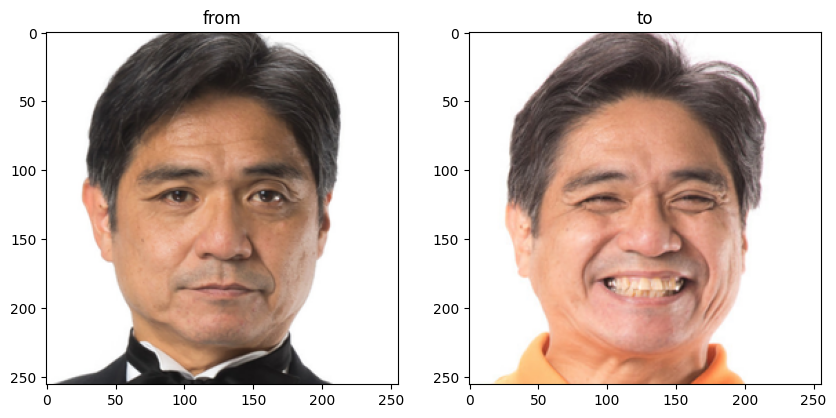

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
title = ["from", "to"]
for i in range(2):
    ax[i].imshow(IMAGES[i])
    # ax[i].axis('off')
    ax[i].set_title(title[i])

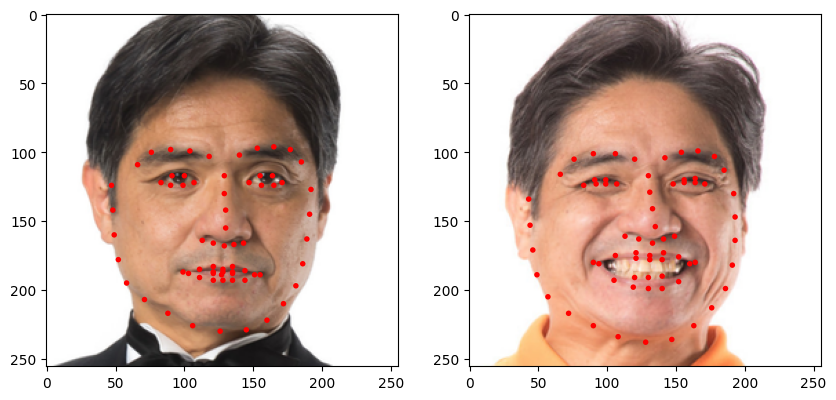

In [7]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, land in enumerate(LANDMARKS):
    ax[i].imshow(IMAGES[i])
    for la in land:
        r = patches.Circle(xy=la, radius=2, fc="r")
        ax[i].add_patch(r)

plt.show()
# plt.savefig('imgs_test/landmark.png')

In [8]:
lm = np.array(LANDMARKS)
lm_eyebrow_left = lm[:, 17:22]  # left-right
lm_eyebrow_right = lm[:, 22:27]  # left-right
lm_nose = lm[:, 27:31]  # top-down
lm_nostrils = lm[:, 31:36]  # top-down
lm_eye_left = lm[:, 36:42]  # left-clockwise
lm_eye_right = lm[:, 42:48]  # left-clockwise
lm_mouth_outer = lm[:, 48:60]  # left-clockwise
lm_mouth_inner = lm[:, 60:68]  # left-clockwise

In [9]:
masks = dict()
crops = dict()

## all

In [10]:
img_from = IMAGES[0].copy()
img_to = IMAGES[1].copy()
pt_from = np.concatenate([lm[0, :17], np.flipud(lm[0, 17:27])])
pt_to = np.concatenate([lm[1, :17], np.flipud(lm[1, 17:27])])

**マスク範囲を若干小さくする（必要であれば実行）**

In [11]:
# pt_from
pt_from_center = pt_from.sum(axis=0) // len(pt_from)
for i in range(17):
    if pt_from[i][0] < pt_from_center[0]:
        pt_from[i][0] += 3
    else:
        pt_from[i][0] -= 3

    if pt_from[i][1] < pt_from_center[1]:
        pt_from[i][1] += 3
    else:
        pt_from[i][1] -= 3

for i in range(17, 27):
    pt_from[i][1] -= 8

# pt_to
pt_to_center = pt_to.sum(axis=0) // len(pt_to)
for i in range(17):
    if pt_to[i][0] < pt_to_center[0]:
        pt_to[i][0] += 3
    else:
        pt_to[i][0] -= 3

    if pt_to[i][1] < pt_to_center[1]:
        pt_to[i][1] += 3
    else:
        pt_to[i][1] -= 3

for i in range(17, 27):
    pt_to[i][1] -= 8

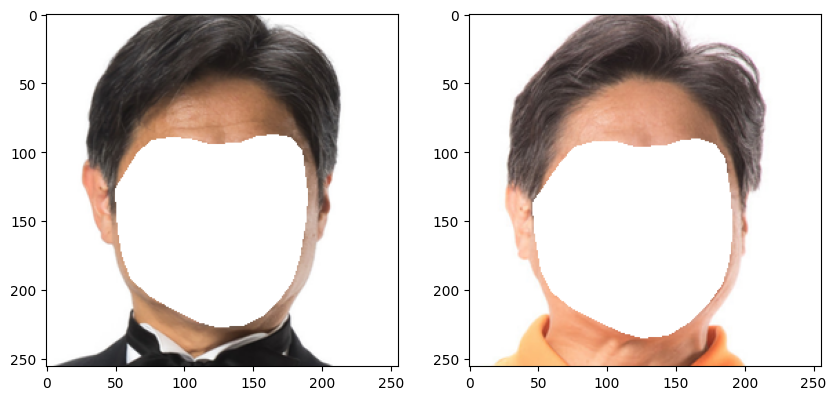

In [12]:
import matplotlib.pyplot as plt

fill_color = (255, 255, 255)
cv2.fillPoly(img_from, [pt_from], fill_color)
cv2.fillPoly(img_to, [pt_to], fill_color)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_from)
ax[1].imshow(img_to)

plt.show()

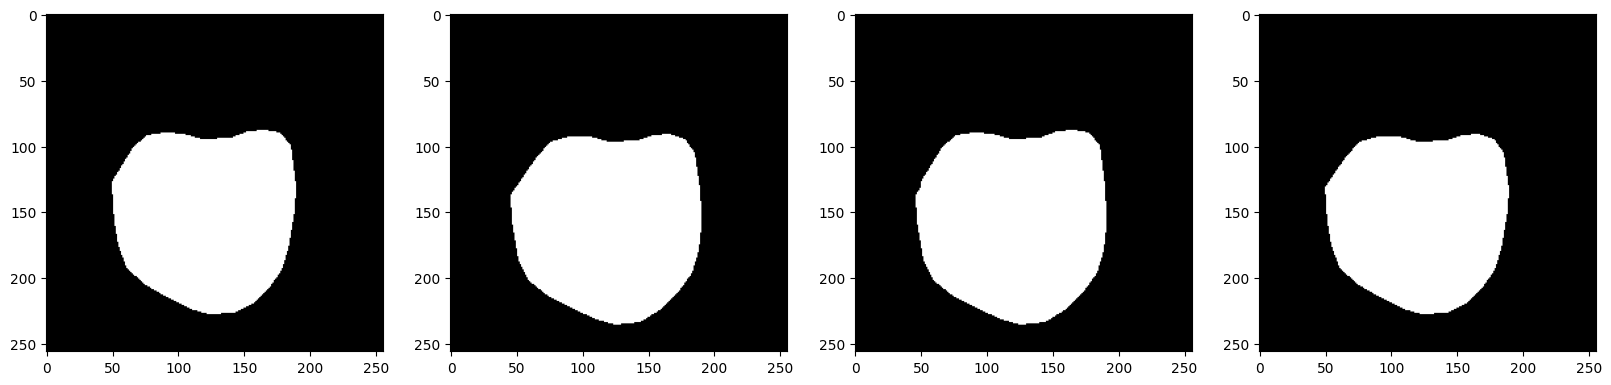

In [13]:
mask = np.zeros(IMAGES[0].shape, IMAGES[0].dtype)
masks["face_from"] = cv2.fillPoly(mask.copy(), [pt_from], (255, 255, 255))
masks["face_to"] = cv2.fillPoly(mask.copy(), [pt_to], (255, 255, 255))
masks["face_or"] = masks["face_from"] | masks["face_to"]
masks["face_and"] = masks["face_from"] & masks["face_to"]

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(masks["face_from"])
ax[1].imshow(masks["face_to"])
ax[2].imshow(masks["face_or"])
ax[3].imshow(masks["face_and"])
plt.show()

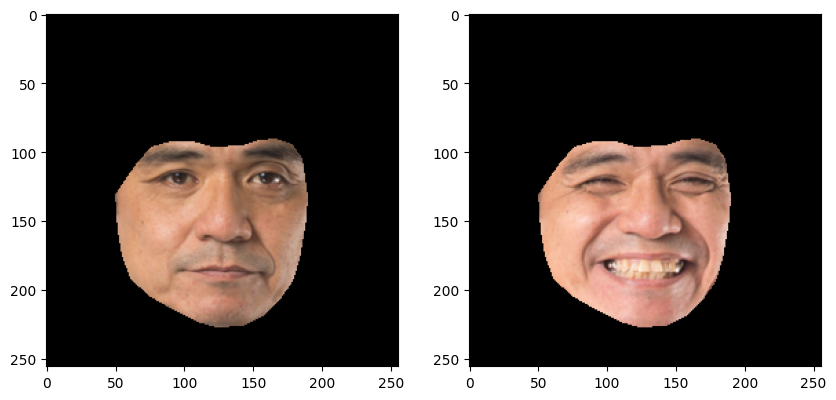

In [14]:
crop = np.zeros(IMAGES[0].shape, IMAGES[0].dtype)
crops["face_from"] = cv2.bitwise_and(IMAGES[0], masks["face_and"])
crops["face_to"] = cv2.bitwise_and(IMAGES[1], masks["face_and"])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(crops["face_from"])
ax[1].imshow(crops["face_to"])
plt.show()

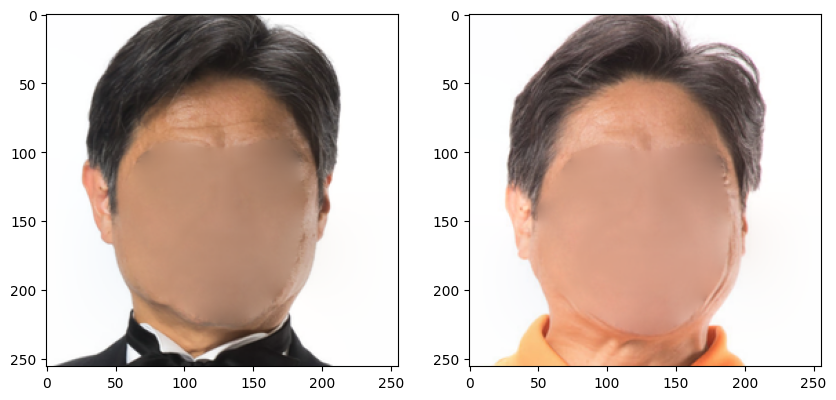

In [15]:
faceless_from = cv2.illuminationChange(IMAGES[0], masks["face_from"], alpha=2, beta=2)
faceless_to = cv2.illuminationChange(IMAGES[1], masks["face_to"], alpha=2, beta=2)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(faceless_from)
ax[1].imshow(faceless_to)
plt.show()

## eye

In [16]:
img_eye_from = IMAGES[0].copy()
img_eye_to = IMAGES[1].copy()
pt_eye_left_from = np.vstack([lm[0, 17:22], lm[0, 39:42], lm[0, 36]])
pt_eye_right_from = np.vstack([lm[0, 22:27], lm[0, 45:48], lm[0, 42]])
pt_eye_left_to = np.vstack([lm[1, 17:22], lm[1, 39:42], lm[1, 36]])
pt_eye_right_to = np.vstack([lm[1, 22:27], lm[1, 45:48], lm[1, 42]])

In [17]:
pt_eye_left_from_center = pt_eye_left_from.sum(axis=0) // len(pt_eye_left_from)
for i in range(len(pt_eye_left_from)):
    if pt_eye_left_from[i][0] < pt_eye_left_from_center[0]:
        pt_eye_left_from[i][0] -= 8
    else:
        pt_eye_left_from[i][0] += 8

    if pt_eye_left_from[i][1] < pt_eye_left_from_center[1]:
        pt_eye_left_from[i][1] -= 8
    else:
        pt_eye_left_from[i][1] += 13

pt_eye_right_from_center = pt_eye_right_from.sum(axis=0) // len(pt_eye_right_from)
for i in range(len(pt_eye_right_from)):
    if pt_eye_right_from[i][0] < pt_eye_right_from_center[0]:
        pt_eye_right_from[i][0] -= 8
    else:
        pt_eye_right_from[i][0] += 8

    if pt_eye_right_from[i][1] < pt_eye_right_from_center[1]:
        pt_eye_right_from[i][1] -= 8
    else:
        pt_eye_right_from[i][1] += 13

pt_eye_left_to_center = pt_eye_left_to.sum(axis=0) // len(pt_eye_left_to)
for i in range(len(pt_eye_left_to)):
    if pt_eye_left_to[i][0] < pt_eye_left_to_center[0]:
        pt_eye_left_to[i][0] -= 8
    else:
        pt_eye_left_to[i][0] += 8

    if pt_eye_left_to[i][1] < pt_eye_left_to_center[1]:
        pt_eye_left_to[i][1] -= 8
    else:
        pt_eye_left_to[i][1] += 13

pt_eye_right_to_center = pt_eye_right_to.sum(axis=0) // len(pt_eye_right_to)
for i in range(len(pt_eye_right_to)):
    if pt_eye_right_to[i][0] < pt_eye_right_to_center[0]:
        pt_eye_right_to[i][0] -= 8
    else:
        pt_eye_right_to[i][0] += 8

    if pt_eye_right_to[i][1] < pt_eye_right_to_center[1]:
        pt_eye_right_to[i][1] -= 8
    else:
        pt_eye_right_to[i][1] += 13

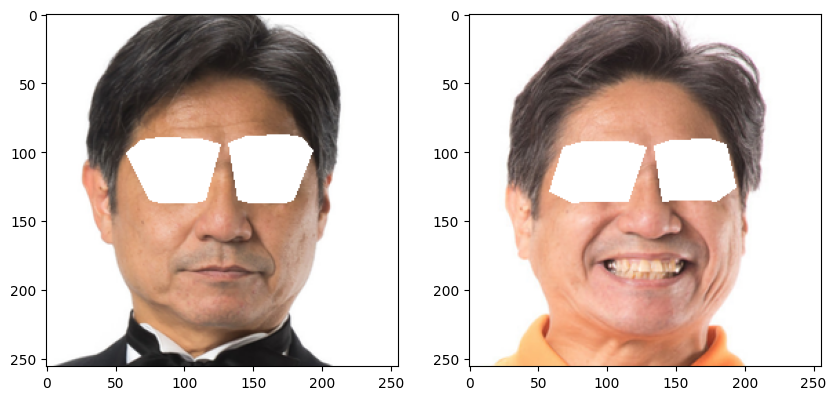

In [18]:
import matplotlib.pyplot as plt

fill_color = (255, 255, 255)
cv2.fillPoly(img_eye_from, [pt_eye_left_from], fill_color)
cv2.fillPoly(img_eye_from, [pt_eye_right_from], fill_color)
cv2.fillPoly(img_eye_to, [pt_eye_left_to], fill_color)
cv2.fillPoly(img_eye_to, [pt_eye_right_to], fill_color)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_eye_from)
ax[1].imshow(img_eye_to)

plt.show()

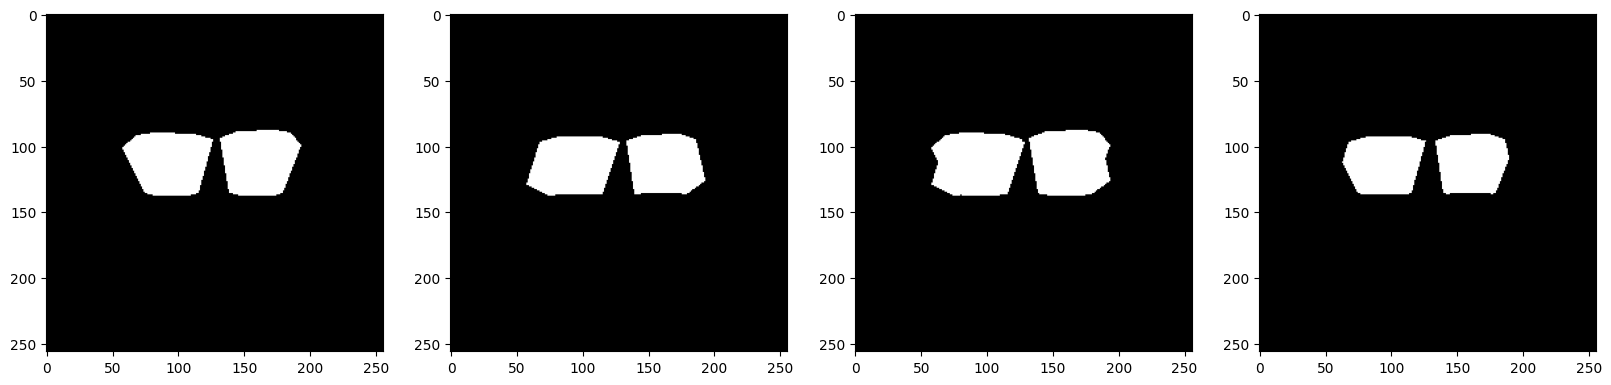

In [19]:
mask = np.zeros(IMAGES[0].shape, IMAGES[0].dtype)
masks["eye_from"] = cv2.fillPoly(mask.copy(), [pt_eye_left_from], (255, 255, 255))
cv2.fillPoly(masks["eye_from"], [pt_eye_right_from], (255, 255, 255))
masks["eye_to"] = cv2.fillPoly(mask.copy(), [pt_eye_left_to], (255, 255, 255))
cv2.fillPoly(masks["eye_to"], [pt_eye_right_to], (255, 255, 255))
masks["eye_or"] = masks["eye_from"] | masks["eye_to"]
masks["eye_and"] = masks["eye_from"] & masks["eye_to"]


fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(masks["eye_from"])
ax[1].imshow(masks["eye_to"])
ax[2].imshow(masks["eye_or"])
ax[3].imshow(masks["eye_and"])
plt.show()

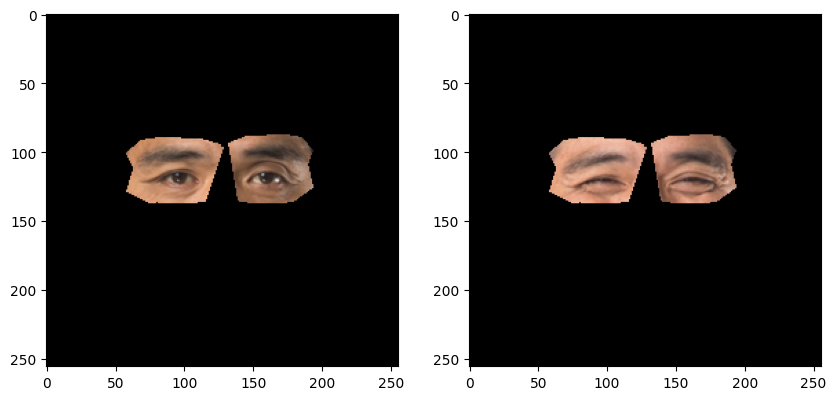

In [20]:
crop_eye = np.zeros(IMAGES[0].shape, IMAGES[0].dtype)
crops["eye_from"] = cv2.bitwise_and(IMAGES[0], masks["eye_or"])
crops["eye_to"] = cv2.bitwise_and(IMAGES[1], masks["eye_or"])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(crops["eye_from"])
ax[1].imshow(crops["eye_to"])
plt.show()

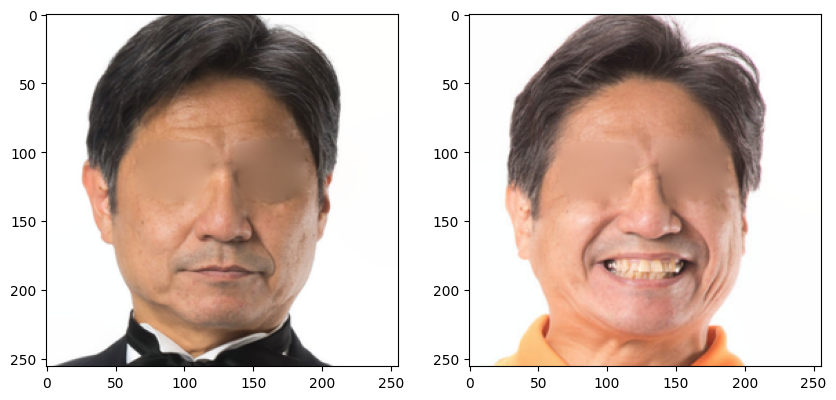

In [21]:
eyeless_from = cv2.illuminationChange(IMAGES[0], masks["eye_or"], alpha=2, beta=2)
eyeless_to = cv2.illuminationChange(IMAGES[1], masks["eye_or"], alpha=2, beta=2)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(eyeless_from)
ax[1].imshow(eyeless_to)
plt.show()

## eye2

eyeを実行してから

In [22]:
img_eye2_from = IMAGES[0].copy()
img_eye2_to = IMAGES[1].copy()

pt_eye2_from = np.vstack([
    pt_eye_left_from.copy()[:5],
    pt_eye_right_from.copy(),
    pt_eye_left_from.copy()[5:]
])
pt_eye2_to = np.vstack([
    pt_eye_left_to.copy()[:5],
    pt_eye_right_to.copy(),
    pt_eye_left_to.copy()[5:]
])

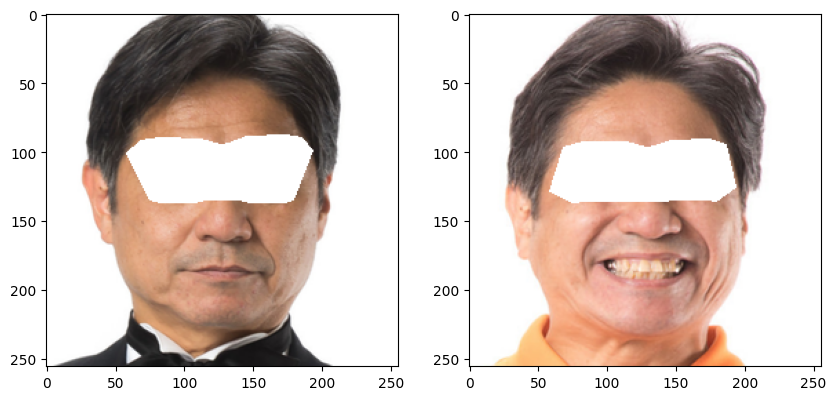

In [23]:
import matplotlib.pyplot as plt

fill_color = (255, 255, 255)
cv2.fillPoly(img_eye2_from, [pt_eye2_from], fill_color)
cv2.fillPoly(img_eye2_to, [pt_eye2_to], fill_color)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_eye2_from)
ax[1].imshow(img_eye2_to)

plt.show()

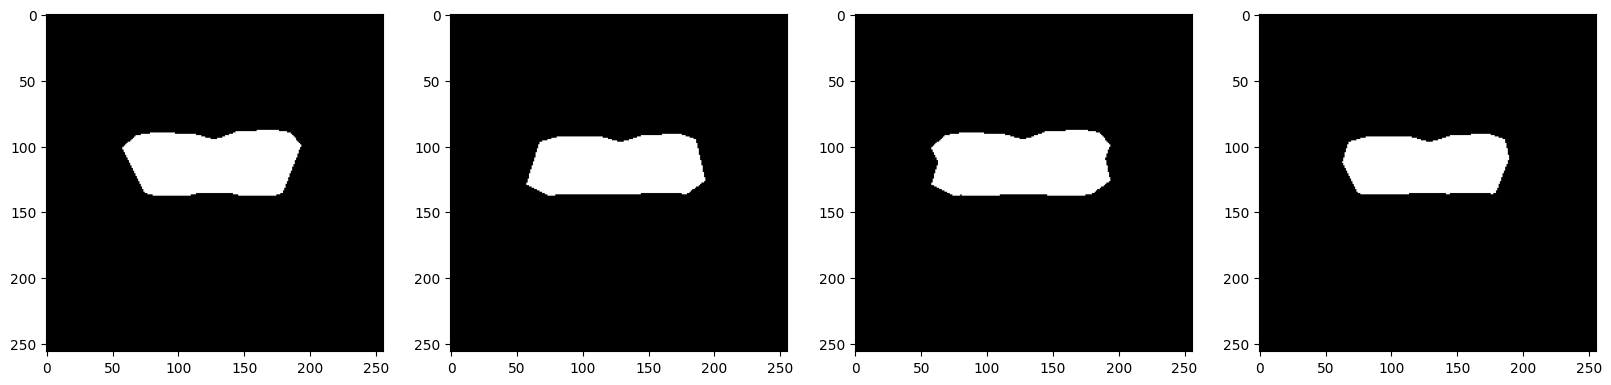

In [24]:
mask = np.zeros(IMAGES[0].shape, IMAGES[0].dtype)
masks["eye2_from"] = cv2.fillPoly(mask.copy(), [pt_eye2_from], (255, 255, 255))
masks["eye2_to"] = cv2.fillPoly(mask.copy(), [pt_eye2_to], (255, 255, 255))
masks["eye2_or"] = masks["eye2_from"] | masks["eye2_to"]
masks["eye2_and"] = masks["eye2_from"] & masks["eye2_to"]

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(masks["eye2_from"])
ax[1].imshow(masks["eye2_to"])
ax[2].imshow(masks["eye2_or"])
ax[3].imshow(masks["eye2_and"])
plt.show()

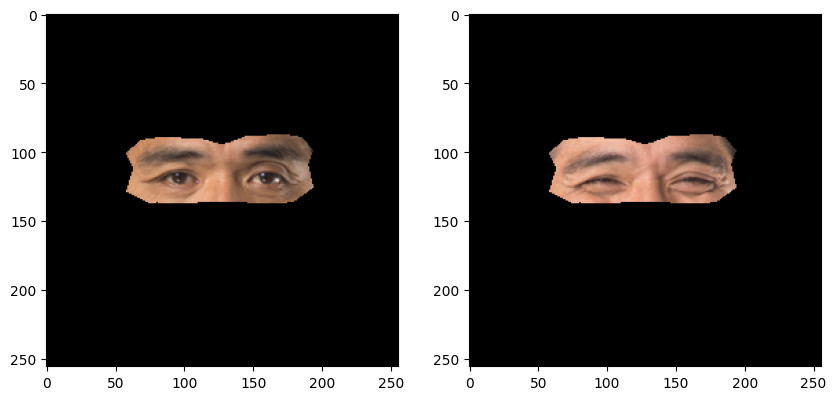

In [25]:
crop_eye2 = np.zeros(IMAGES[0].shape, IMAGES[0].dtype)
crops["eye2_from"] = cv2.bitwise_and(IMAGES[0], masks["eye2_or"])
crops["eye2_to"] = cv2.bitwise_and(IMAGES[1], masks["eye2_or"])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(crops["eye2_from"])
ax[1].imshow(crops["eye2_to"])
plt.show()

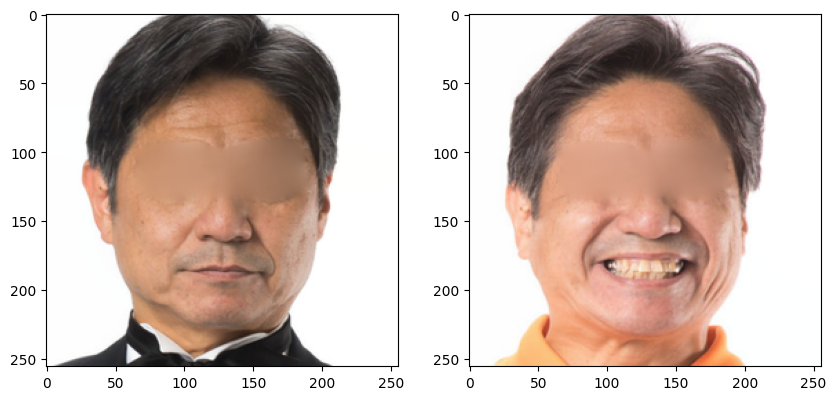

In [26]:
eye2less_from = cv2.illuminationChange(IMAGES[0], masks["eye2_or"], alpha=2, beta=2)
eye2less_to = cv2.illuminationChange(IMAGES[1], masks["eye2_or"], alpha=2, beta=2)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(eye2less_from)
ax[1].imshow(eye2less_to)
plt.show()

## mouth

In [27]:
img_mouth_from = IMAGES[0].copy()
img_mouth_to = IMAGES[1].copy()
pt_mouth_from = lm[0, 48:60].copy()
pt_mouth_to = lm[1, 48:60].copy()

In [28]:
pt_mouth_from_center = pt_mouth_from.sum(axis=0) // len(pt_mouth_from)
for i in range(len(pt_mouth_from)):
    if pt_mouth_from[i][0] < pt_mouth_from_center[0]:
        pt_mouth_from[i][0] -= 15
    else:
        pt_mouth_from[i][0] += 15

    if pt_mouth_from[i][1] < pt_mouth_from_center[1]:
        pt_mouth_from[i][1] -= 10
    else:
        pt_mouth_from[i][1] += 10

pt_mouth_to_center = pt_mouth_to.sum(axis=0) // len(pt_mouth_to)
for i in range(len(pt_mouth_to)):
    if pt_mouth_to[i][0] < pt_mouth_to_center[0]:
        pt_mouth_to[i][0] -= 15
    else:
        pt_mouth_to[i][0] += 15

    if pt_mouth_to[i][1] < pt_mouth_to_center[1]:
        pt_mouth_to[i][1] -= 10
    else:
        pt_mouth_to[i][1] += 10

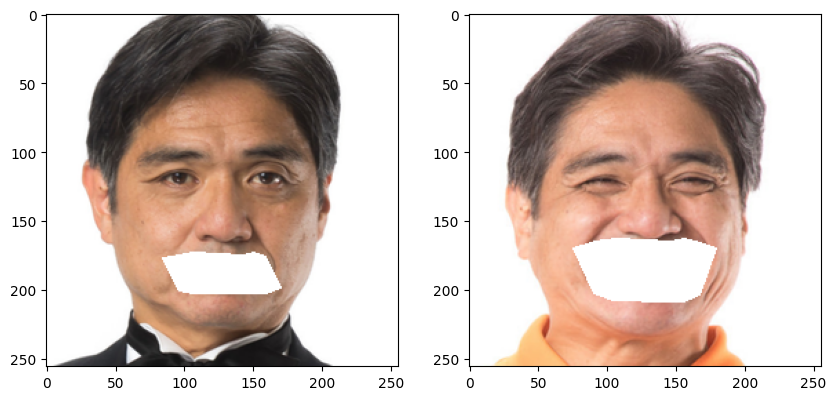

In [29]:
import matplotlib.pyplot as plt

fill_color = (255, 255, 255)
cv2.fillPoly(img_mouth_from, [pt_mouth_from], fill_color)
cv2.fillPoly(img_mouth_to, [pt_mouth_to], fill_color)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_mouth_from)
ax[1].imshow(img_mouth_to)

plt.show()

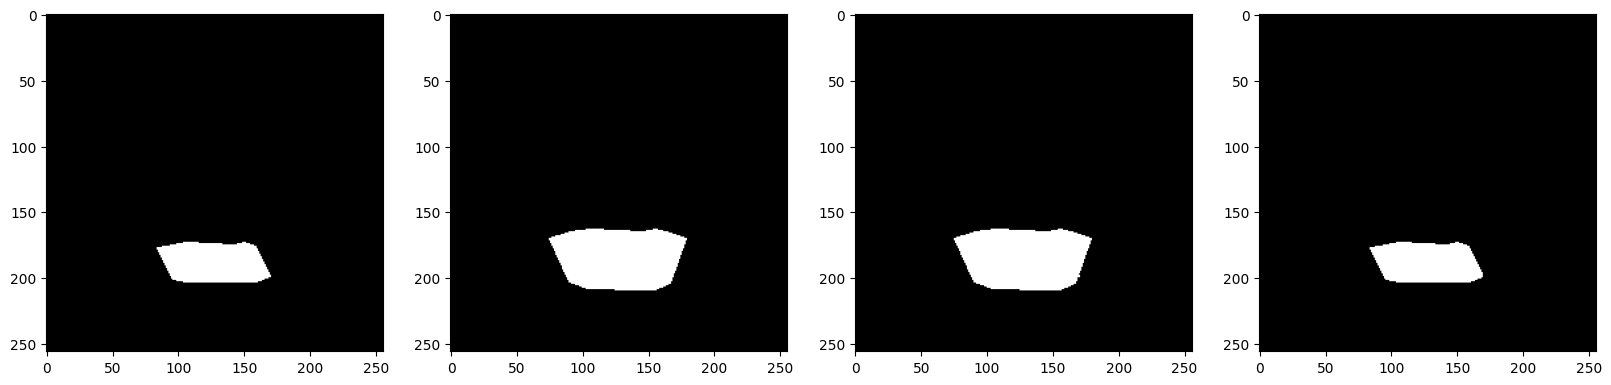

In [30]:
mask = np.zeros(IMAGES[0].shape, IMAGES[0].dtype)
masks["mouth_from"] = cv2.fillPoly(mask.copy(), [pt_mouth_from], (255, 255, 255))
masks["mouth_to"] = cv2.fillPoly(mask.copy(), [pt_mouth_to], (255, 255, 255))
masks["mouth_or"] = masks["mouth_from"] | masks["mouth_to"]
masks["mouth_and"] = masks["mouth_from"] & masks["mouth_to"]

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(masks["mouth_from"])
ax[1].imshow(masks["mouth_to"])
ax[2].imshow(masks["mouth_or"])
ax[3].imshow(masks["mouth_and"])
plt.show()

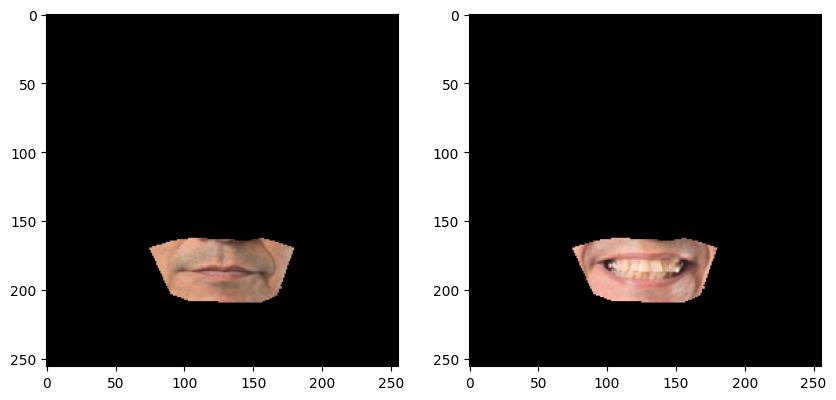

In [31]:
crop_mouth = np.zeros(IMAGES[0].shape, IMAGES[0].dtype)
crops["mouth_from"] = cv2.bitwise_and(IMAGES[0], masks["mouth_or"])
crops["mouth_to"] = cv2.bitwise_and(IMAGES[1], masks["mouth_or"])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(crops["mouth_from"])
ax[1].imshow(crops["mouth_to"])
plt.show()

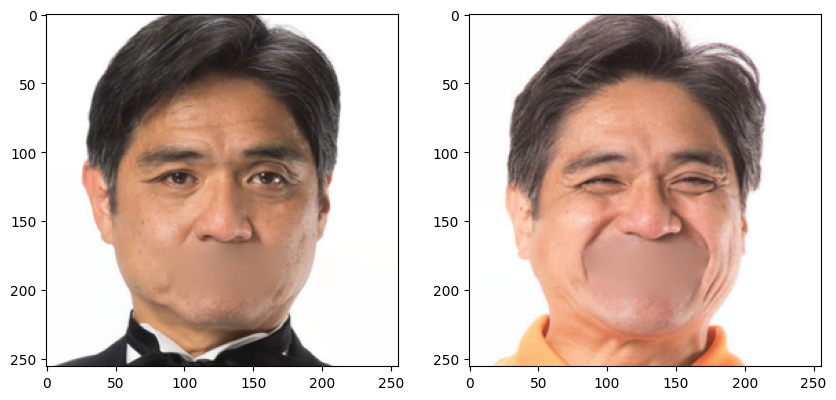

In [32]:
mouthless_from = cv2.illuminationChange(IMAGES[0], masks["mouth_or"], alpha=2, beta=2)
mouthless_to = cv2.illuminationChange(IMAGES[1], masks["mouth_or"], alpha=2, beta=2)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(mouthless_from)
ax[1].imshow(mouthless_to)
plt.show()

## eye&mouth

eye, mouthを実行してから

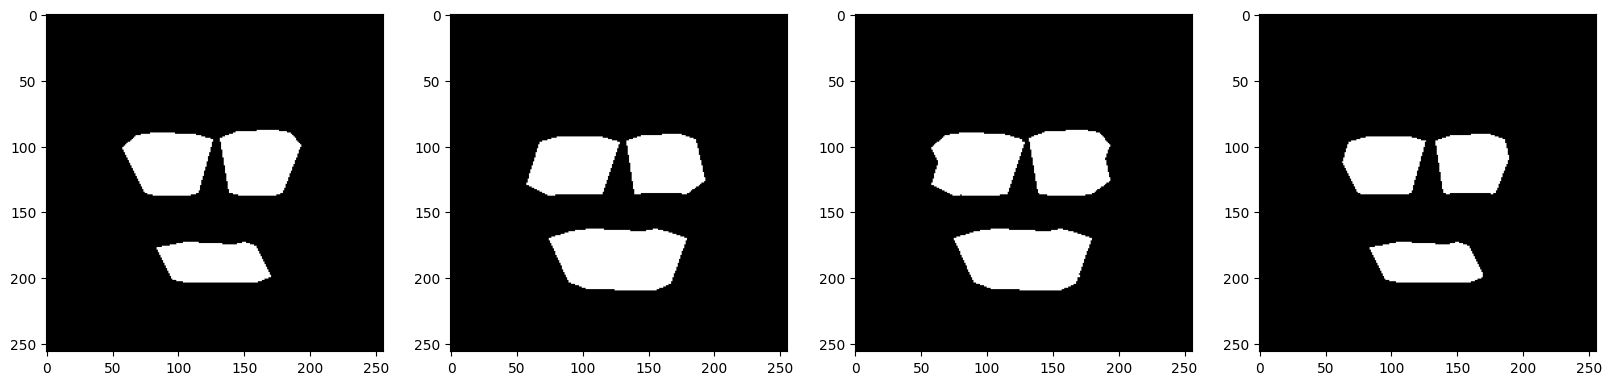

In [33]:
masks["eye_mouth_from"] = cv2.fillPoly(masks["eye_from"].copy(), [pt_mouth_from], (255, 255, 255))
masks["eye_mouth_to"] = cv2.fillPoly(masks["eye_to"].copy(), [pt_mouth_to], (255, 255, 255))
masks["eye_mouth_or"] = masks["eye_mouth_from"] | masks["eye_mouth_to"]
masks["eye_mouth_and"] = masks["eye_mouth_from"] & masks["eye_mouth_to"]

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(masks["eye_mouth_from"])
ax[1].imshow(masks["eye_mouth_to"])
ax[2].imshow(masks["eye_mouth_or"])
ax[3].imshow(masks["eye_mouth_and"])
plt.show()

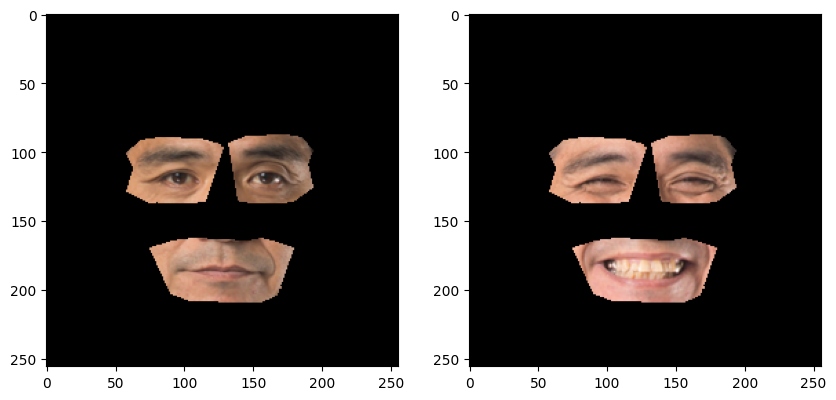

In [34]:
crop_eye_mouth = np.zeros(IMAGES[0].shape, IMAGES[0].dtype)
crops["eye_mouth_from"] = cv2.bitwise_and(IMAGES[0], masks["eye_mouth_or"])
crops["eye_mouth_to"] = cv2.bitwise_and(IMAGES[1], masks["eye_mouth_or"])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(crops["eye_mouth_from"])
ax[1].imshow(crops["eye_mouth_to"])
plt.show()

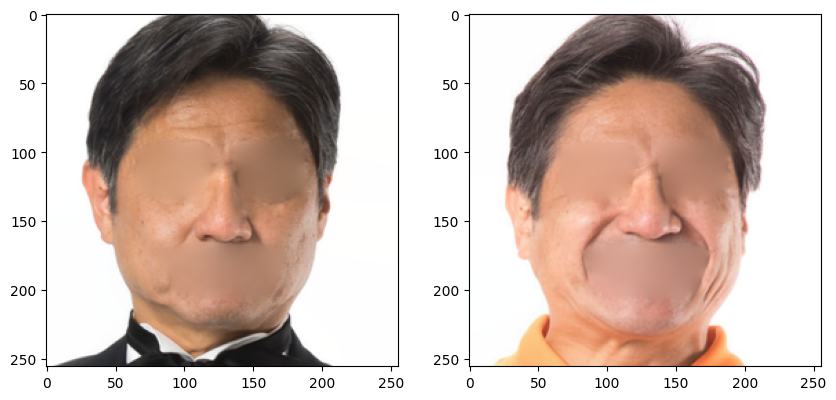

In [35]:
eye_mouth_less_from = cv2.illuminationChange(
    IMAGES[0], masks["eye_mouth_or"], alpha=2, beta=2
)
eye_mouth_less_to = cv2.illuminationChange(
    IMAGES[1], masks["eye_mouth_or"], alpha=2, beta=2
)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(eye_mouth_less_from)
ax[1].imshow(eye_mouth_less_to)
plt.show()

## eye2&mouth

eye2, mouthを実行してから

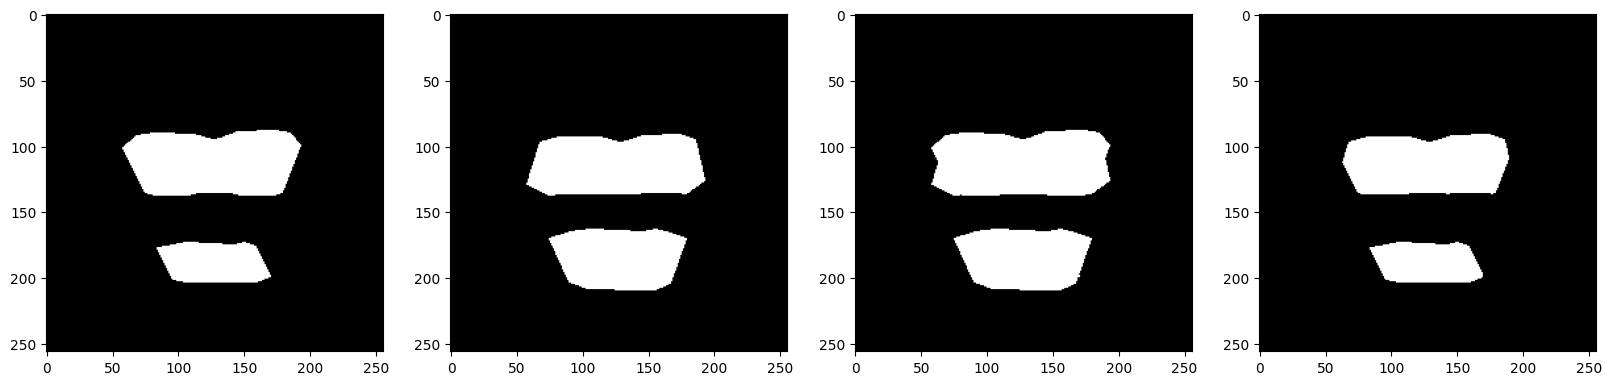

In [36]:
masks["eye2_mouth_from"] = cv2.fillPoly(masks["eye2_from"].copy(), [pt_mouth_from], (255, 255, 255))
masks["eye2_mouth_to"] = cv2.fillPoly(masks["eye2_to"].copy(), [pt_mouth_to], (255, 255, 255))
masks["eye2_mouth_or"] = masks["eye2_mouth_from"] | masks["eye2_mouth_to"]
masks["eye2_mouth_and"] = masks["eye2_mouth_from"] & masks["eye2_mouth_to"]

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(masks["eye2_mouth_from"])
ax[1].imshow(masks["eye2_mouth_to"])
ax[2].imshow(masks["eye2_mouth_or"])
ax[3].imshow(masks["eye2_mouth_and"])
plt.show()

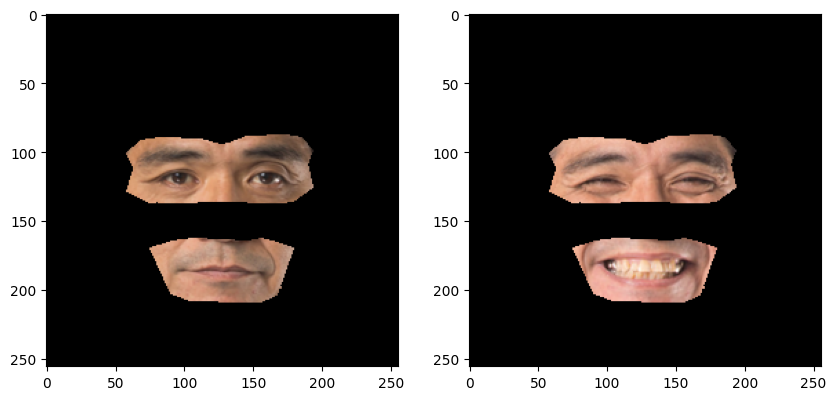

In [37]:
crop_eye2_mouth = np.zeros(IMAGES[0].shape, IMAGES[0].dtype)
crops["eye2_mouth_from"] = cv2.bitwise_and(IMAGES[0], masks["eye2_mouth_or"])
crops["eye2_mouth_to"] = cv2.bitwise_and(IMAGES[1], masks["eye2_mouth_or"])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(crops["eye2_mouth_from"])
ax[1].imshow(crops["eye2_mouth_to"])
plt.show()

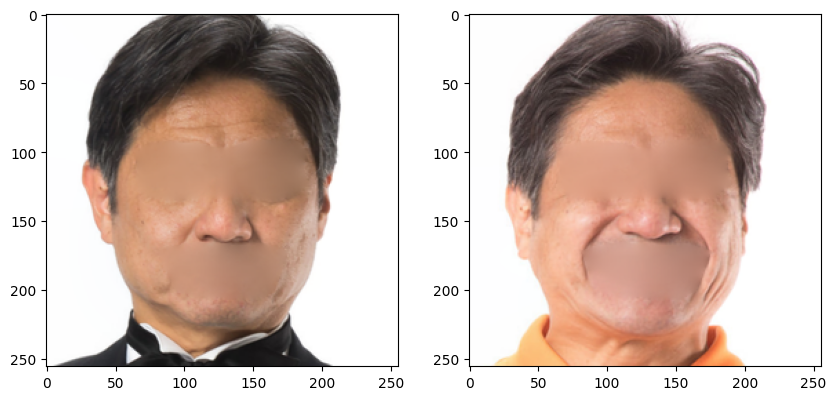

In [38]:
eye2_mouth_less_from = cv2.illuminationChange(
    IMAGES[0], masks["eye2_mouth_or"], alpha=2, beta=2
)
eye2_mouth_less_to = cv2.illuminationChange(
    IMAGES[1], masks["eye2_mouth_or"], alpha=2, beta=2
)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(eye2_mouth_less_from)
ax[1].imshow(eye2_mouth_less_to)
plt.show()

## mouth&nose

In [39]:
img_mouth_nose_from = IMAGES[0].copy()
img_mouth_nose_to = IMAGES[1].copy()
pt_mouth_nose_from = np.vstack([lm[0, 36], lm[0, 45], lm[0, 54:60], lm[0, 48]])
pt_mouth_nose_to = np.vstack([lm[1, 36], lm[1, 45], lm[1, 54:60], lm[1, 48]])

In [40]:
pt_mouth_nose_from_center = pt_mouth_nose_from.sum(axis=0) // len(pt_mouth_nose_from)
for i in range(len(pt_mouth_nose_from)):
    if i < 2:
        pt_mouth_nose_from[i][1] += 15
    else:    
        if pt_mouth_nose_from[i][0] < pt_mouth_nose_from_center[0]:
            pt_mouth_nose_from[i][0] -= 15
        else:
            pt_mouth_nose_from[i][0] += 15
    
        if pt_mouth_nose_from[i][1] < pt_mouth_nose_from_center[1]:
            pt_mouth_nose_from[i][1] -= 0
        else:
            pt_mouth_nose_from[i][1] += 10

pt_mouth_nose_to_center = pt_mouth_nose_to.sum(axis=0) // len(pt_mouth_nose_to)
for i in range(len(pt_mouth_nose_to)):
    if i < 2:
        pt_mouth_nose_to[i][1] += 15
    else:    
        if pt_mouth_nose_to[i][0] < pt_mouth_nose_to_center[0]:
            pt_mouth_nose_to[i][0] -= 15
        else:
            pt_mouth_nose_to[i][0] += 15
    
        if pt_mouth_nose_to[i][1] < pt_mouth_nose_to_center[1]:
            pt_mouth_nose_to[i][1] -= 0
        else:
            pt_mouth_nose_to[i][1] += 10

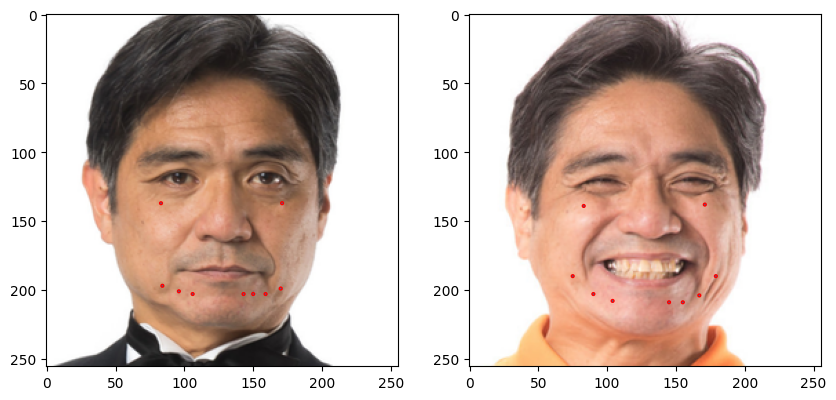

In [41]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(IMAGES[0])
for la in pt_mouth_nose_from:
    r = patches.Circle(xy=la, radius=1, ec="r")
    ax[0].add_patch(r)
    
ax[1].imshow(IMAGES[1])
for la in pt_mouth_nose_to:
    r = patches.Circle(xy=la, radius=1, ec="r")
    ax[1].add_patch(r)
plt.show()

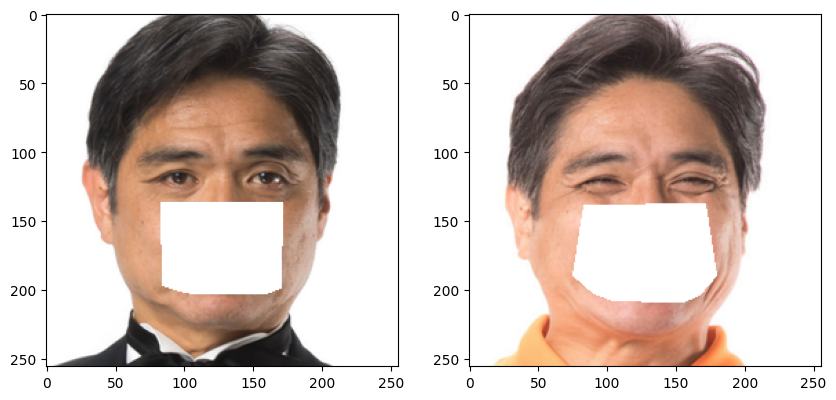

In [42]:
import matplotlib.pyplot as plt

fill_color = (255, 255, 255)
cv2.fillPoly(img_mouth_nose_from, [pt_mouth_nose_from], fill_color)
cv2.fillPoly(img_mouth_nose_to, [pt_mouth_nose_to], fill_color)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_mouth_nose_from)
ax[1].imshow(img_mouth_nose_to)

plt.show()

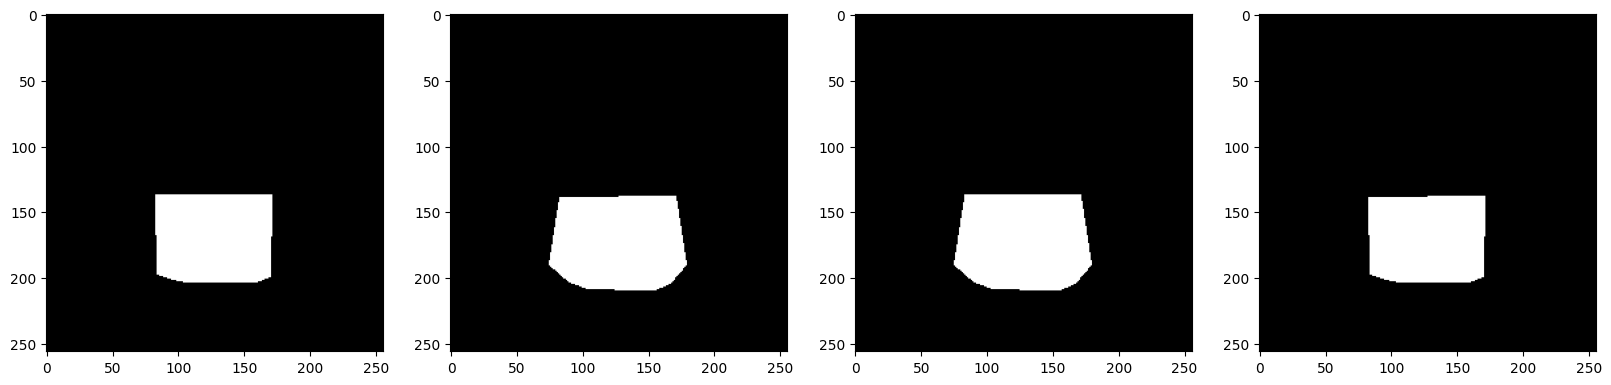

In [43]:
mask = np.zeros(IMAGES[0].shape, IMAGES[0].dtype)
masks["mouth_nose_from"] = cv2.fillPoly(mask.copy(), [pt_mouth_nose_from], (255, 255, 255))
masks["mouth_nose_to"] = cv2.fillPoly(mask.copy(), [pt_mouth_nose_to], (255, 255, 255))
masks["mouth_nose_or"] = masks["mouth_nose_from"] | masks["mouth_nose_to"]
masks["mouth_nose_and"] = masks["mouth_nose_from"] & masks["mouth_nose_to"]

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(masks["mouth_nose_from"])
ax[1].imshow(masks["mouth_nose_to"])
ax[2].imshow(masks["mouth_nose_or"])
ax[3].imshow(masks["mouth_nose_and"])
plt.show()

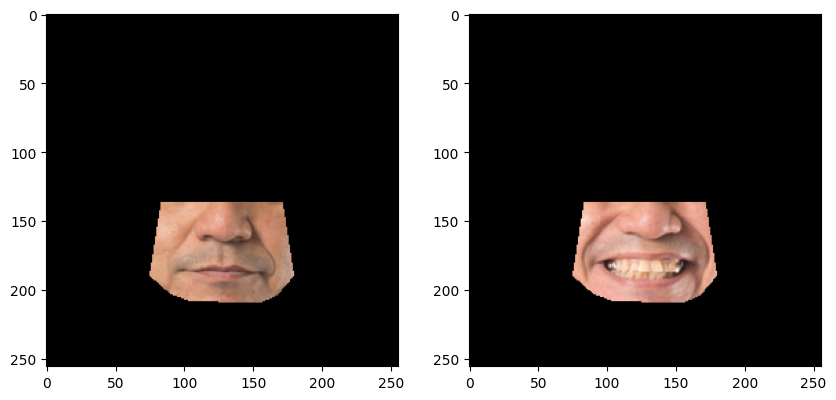

In [44]:
crop_mouth_nose = np.zeros(IMAGES[0].shape, IMAGES[0].dtype)
crops["mouth_nose_from"] = cv2.bitwise_and(IMAGES[0], masks["mouth_nose_or"])
crops["mouth_nose_to"] = cv2.bitwise_and(IMAGES[1], masks["mouth_nose_or"])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(crops["mouth_nose_from"])
ax[1].imshow(crops["mouth_nose_to"])
plt.show()

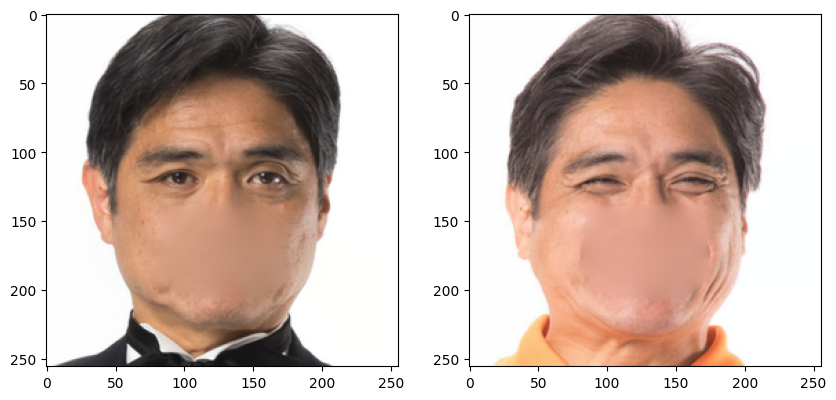

In [45]:
mouth_nose_less_from = cv2.illuminationChange(IMAGES[0], masks["mouth_nose_or"], alpha=2, beta=2)
mouth_nose_less_to = cv2.illuminationChange(IMAGES[1], masks["mouth_nose_or"], alpha=2, beta=2)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(mouth_nose_less_from)
ax[1].imshow(mouth_nose_less_to)
plt.show()

## 合成

### face-all

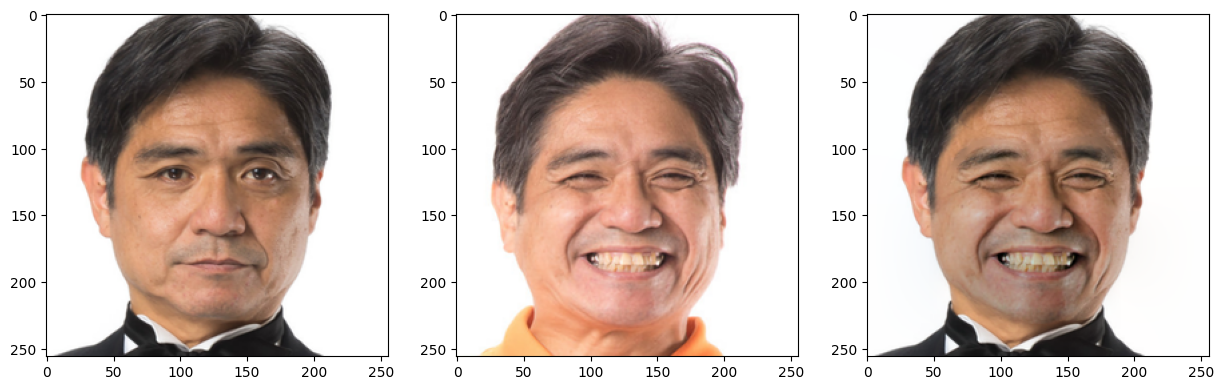

In [46]:
monoMaskImage = cv2.split(masks["face_to"])[0] # reducing the mask to a monochrome
br = cv2.boundingRect(monoMaskImage) # bounding rect (x,y,width,height)
center = (br[0] + br[2] // 2, br[1] + br[3] // 2)
result = cv2.seamlessClone(IMAGES[1], faceless_from, masks["face_to"], center, cv2.NORMAL_CLONE)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(IMAGES[0])
ax[1].imshow(IMAGES[1])
ax[2].imshow(result)
# for i in range(3):
#     ax[i].grid()
plt.show()

### eye

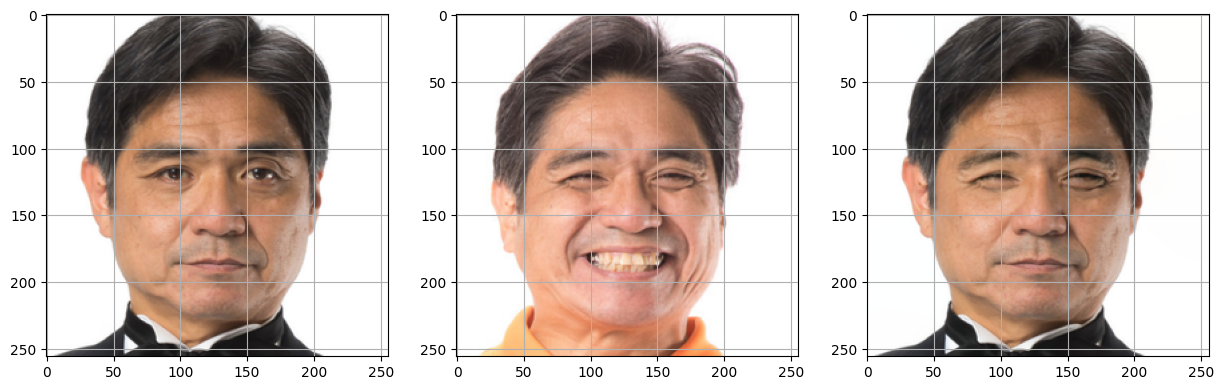

In [47]:
monoMaskImage = cv2.split(masks["eye_to"])[0] # reducing the mask to a monochrome
br = cv2.boundingRect(monoMaskImage) # bounding rect (x,y,width,height)
center = (br[0] + br[2] // 2, br[1] + br[3] // 2)
result_eye = cv2.seamlessClone(IMAGES[1], eyeless_from, masks["eye_to"], center, cv2.NORMAL_CLONE)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(IMAGES[0])
ax[1].imshow(IMAGES[1])
ax[2].imshow(result_eye)
for i in range(3):
    ax[i].grid()
plt.show()

### eye2

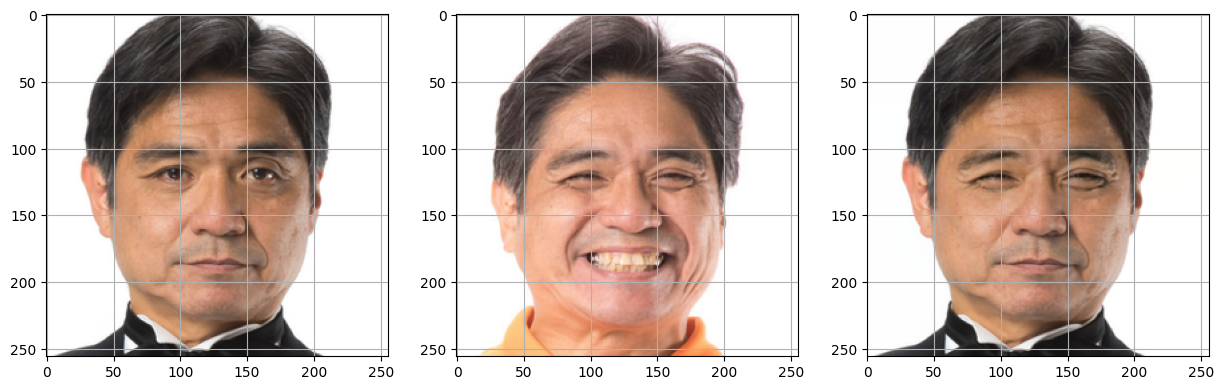

In [48]:
monoMaskImage = cv2.split(masks["eye2_to"])[0] # reducing the mask to a monochrome
br = cv2.boundingRect(monoMaskImage) # bounding rect (x,y,width,height)
center = (br[0] + br[2] // 2, br[1] + br[3] // 2)
result_eye2 = cv2.seamlessClone(IMAGES[1], eye2less_from, masks["eye2_to"], center, cv2.NORMAL_CLONE)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(IMAGES[0])
ax[1].imshow(IMAGES[1])
ax[2].imshow(result_eye2)
for i in range(3):
    ax[i].grid()
plt.show()

### mouth

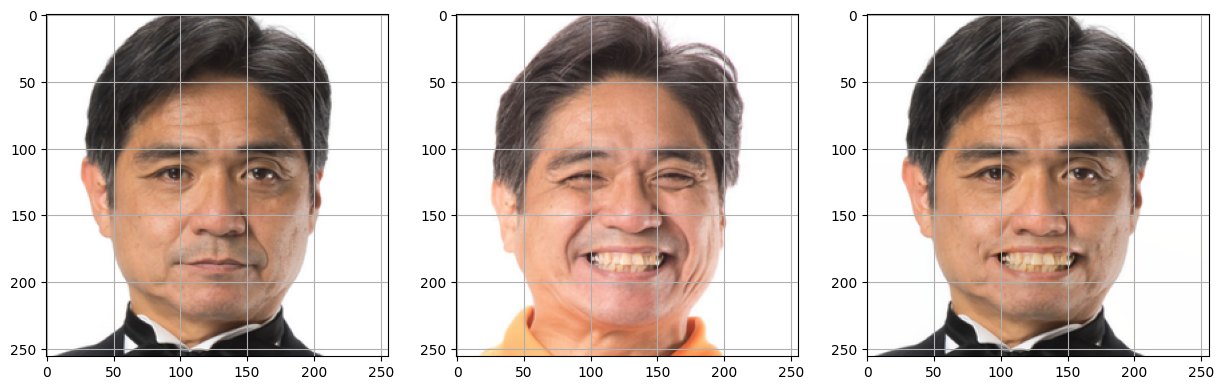

In [49]:
monoMaskImage = cv2.split(masks["mouth_to"])[0] # reducing the mask to a monochrome
br = cv2.boundingRect(monoMaskImage) # bounding rect (x,y,width,height)
center = (br[0] + br[2] // 2, br[1] + br[3] // 2)
result_mouth = cv2.seamlessClone(IMAGES[1], mouthless_from, masks["mouth_to"], center, cv2.NORMAL_CLONE)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(IMAGES[0])
ax[1].imshow(IMAGES[1])
ax[2].imshow(result_mouth)
for i in range(3):
    ax[i].grid()
plt.show()

### eye&mouth

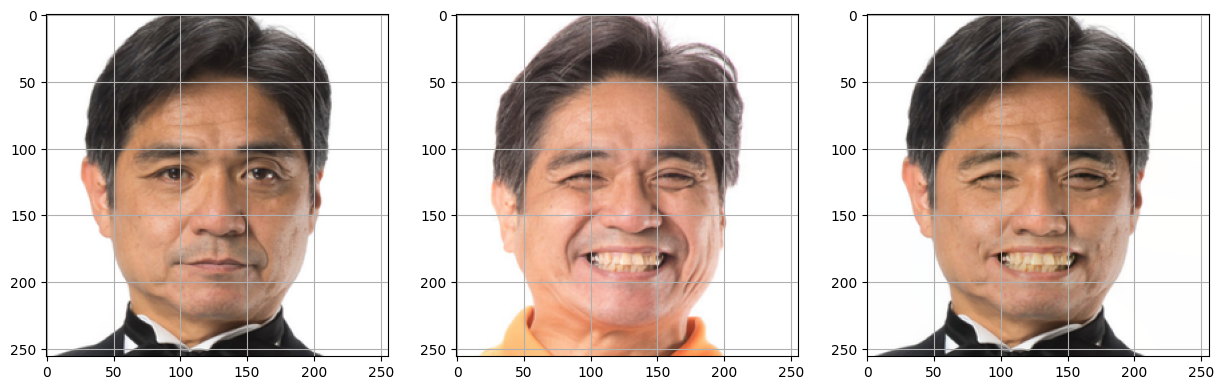

In [50]:
monoMaskImage = cv2.split(masks["eye_mouth_to"])[0] # reducing the mask to a monochrome
br = cv2.boundingRect(monoMaskImage) # bounding rect (x,y,width,height)
center = (br[0] + br[2] // 2, br[1] + br[3] // 2)
result_eye_mouth = cv2.seamlessClone(IMAGES[1], eye_mouth_less_from, masks["eye_mouth_to"], center, cv2.NORMAL_CLONE)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(IMAGES[0])
ax[1].imshow(IMAGES[1])
ax[2].imshow(result_eye_mouth)
for i in range(3):
    ax[i].grid()
plt.show()

### eye2&mouth

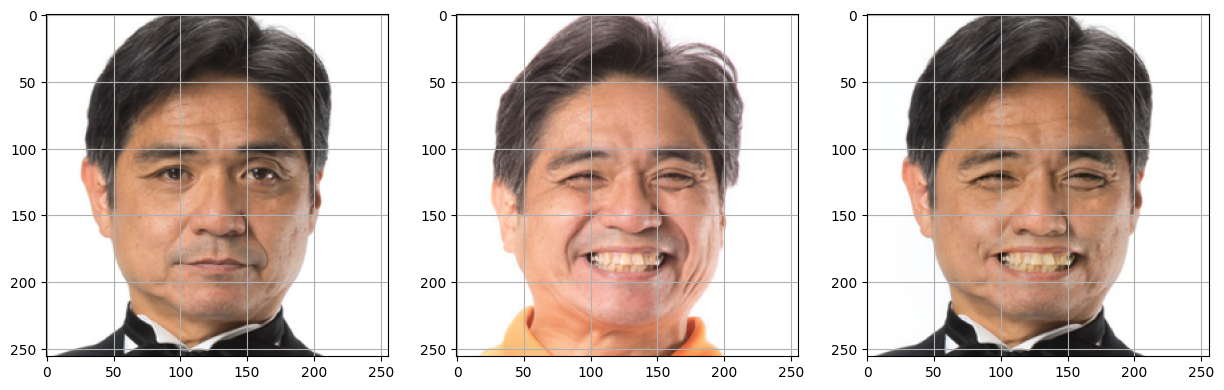

In [51]:
monoMaskImage = cv2.split(masks["eye2_mouth_to"])[0] # reducing the mask to a monochrome
br = cv2.boundingRect(monoMaskImage) # bounding rect (x,y,width,height)
center = (br[0] + br[2] // 2, br[1] + br[3] // 2)
result_eye2_mouth = cv2.seamlessClone(IMAGES[1], eye2_mouth_less_from, masks["eye2_mouth_to"], center, cv2.NORMAL_CLONE)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(IMAGES[0])
ax[1].imshow(IMAGES[1])
ax[2].imshow(result_eye2_mouth)
for i in range(3):
    ax[i].grid()
plt.show()

### mouth&nose

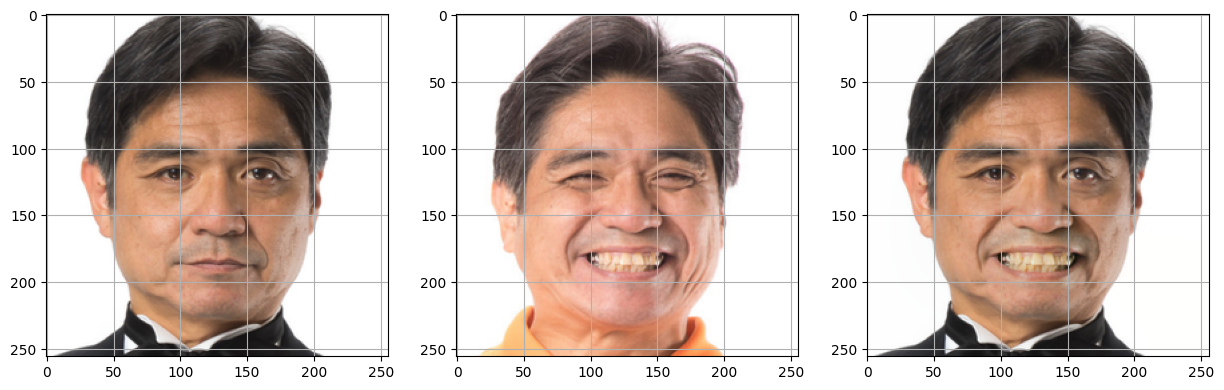

In [52]:
monoMaskImage = cv2.split(masks["mouth_nose_to"])[0] # reducing the mask to a monochrome
br = cv2.boundingRect(monoMaskImage) # bounding rect (x,y,width,height)
center = (br[0] + br[2] // 2, br[1] + br[3] // 2)
result_mouth_nose = cv2.seamlessClone(IMAGES[1], mouth_nose_less_from, masks["mouth_nose_to"], center, cv2.NORMAL_CLONE)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(IMAGES[0])
ax[1].imshow(IMAGES[1])
ax[2].imshow(result_mouth_nose)
for i in range(3):
    ax[i].grid()
plt.show()

## 保存

In [53]:
dst_dir = f"test/crop/{IMAGES_NAME[0]}-{IMAGES_NAME[1]}"
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)

list_parts = ["face_from", "face_to", "eye2_from", "eye2_to", "mouth_from", "mouth_to", "eye2_mouth_from", "eye2_mouth_to", "mouth_nose_from", "mouth_nose_to"]

for lsp in list_parts:
    cv2.imwrite(
        f"{dst_dir}/{lsp}.png",
        cv2.cvtColor(crops[lsp], cv2.COLOR_RGB2BGR),
    )

In [54]:
cv2.imwrite(
        f"{dst_dir}/all_from.png",
        cv2.cvtColor(IMAGES[0], cv2.COLOR_RGB2BGR),
    )
cv2.imwrite(
        f"{dst_dir}/all_to.png",
        cv2.cvtColor(IMAGES[1], cv2.COLOR_RGB2BGR),
    )
cv2.imwrite(
        f"{dst_dir}/pose_from.png",
        cv2.cvtColor(faceless_from, cv2.COLOR_RGB2BGR),
    )
cv2.imwrite(
        f"{dst_dir}/pose_to.png",
        cv2.cvtColor(faceless_to, cv2.COLOR_RGB2BGR),
    )

True